In [273]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [274]:
def gen_sample(batch_size, N_agents, in_dim = None, L = None):
    """ 
        generates an inital states in [0,L1] x [0,L2] x ... x [0, Ln] of shape [Batch_size, in_dim]
    """
    if in_dim is None and L is None:
        raise ValueError("Need either L or in dim to be set")
    if in_dim is None:
        in_dim = len(L)
    if L is None:
        L = [1. for _ in range(in_dim)]
    x = torch.rand(batch_size, N_agents, in_dim).abs()
    for i in range(len(L)):
        x[:, :, i] = torch.clamp(x[:, :, i], max=L[i])
    return x


In [275]:
N_Agents = 2
in_dim = 1
batch_size = 128
num_samples = 1000 ## samples linspace of target and objective funciton
n_samples = 2048 ## samples per epoch TODO better naming
timesteps = 30
lam = 0.5
control_energy_reg = 1e-6 ### regularization on maximum control energy
u_max = 100 # does not do anything currently
thres = -1e-2 ### softness on constraint (will penalize when this much outside of rect)


In [276]:
densties = ['custom']
regions = [
        torch.tensor([[.0, .3]]),
        torch.tensor([[.6, .9]])
        ]
weights = [.5, .5]

In [277]:
def custom_pdf(x):
    """
     Define a custom probability density function (PDF).
    """
    #x = x.item()
    return torch.tensor(np.where(((x > 0) & (x < 1)), 1., 0), dtype = torch.float32)
    #return torch.tensor(np.where(((x > 0) & (x < 0.3)) | ((x > 0.6) & (x < 0.9)), 5 / 3, 0))

In [278]:
import Ergodic_Loss_timedomain
import Recursive_KAN
import sys
sys.path.append(r'\\hhi.de\benutzer\home\prass\Master\Code_RNN_KAN\Recursive_kan\Ergodic_Loss_timedomain.py') 
sys.path.append(r'\\hhi.de\benutzer\home\prass\Master\Code_RNN_KAN\Recursive_kan\Recursive_KAN.py') 
import importlib
importlib.reload(Ergodic_Loss_timedomain)
importlib.reload(Recursive_KAN)
criterion = Ergodic_Loss_timedomain.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, control_energy_reg = control_energy_reg, density = 'custom',verbose = False, pdf = custom_pdf, num_samples = num_samples)
model = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 128, depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', thres = thres)
model.init_hidden(batch_size = batch_size)

In [279]:
exploding_threshold = 1e5  # Example threshold for exploding gradients
vanishing_threshold = 1e-5  # Example threshold for vanishing gradients
def print_grad(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()  # Gradient norm (magnitude)
            if grad_norm > exploding_threshold:
                print(f"  *** Exploding gradient detected for {name} ***")
            elif grad_norm < vanishing_threshold:
                print(f"  *** Vanishing gradient detected for {name} ***")


In [280]:
import time
criterion.verbose = False
epochs = 15  # Number of epochs to train
optimizer = optim.AdamW(model.parameters(), lr=0.001)
train_loss = []
test_loss = []
model.train()  # Set the model to training mode
show = True
for epoch in range(epochs):
    running_loss = 0.0 
    for samples in range(n_samples // batch_size):
        start_time = time.time()
        model.init_hidden(batch_size = batch_size)
        optimizer.zero_grad()
        control , outputs = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
        loss = criterion(x = outputs, u = control) + model.penalty #* 1e-2 ## punishment on leaving the rect
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #print_grad(model)
        if show:
            show = False
            print("per iter:", time.time()- start_time,"total time:" , (time.time()- start_time) * (n_samples / batch_size) * epochs)
    avg_loss = running_loss / (n_samples // batch_size)
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
plt.plot(train_loss)
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

per iter: 1.0450694561004639 total time: 250.81666946411133
Epoch [1/15], Loss: 31.013841
Epoch [2/15], Loss: 15.366493
Epoch [3/15], Loss: 12.645224


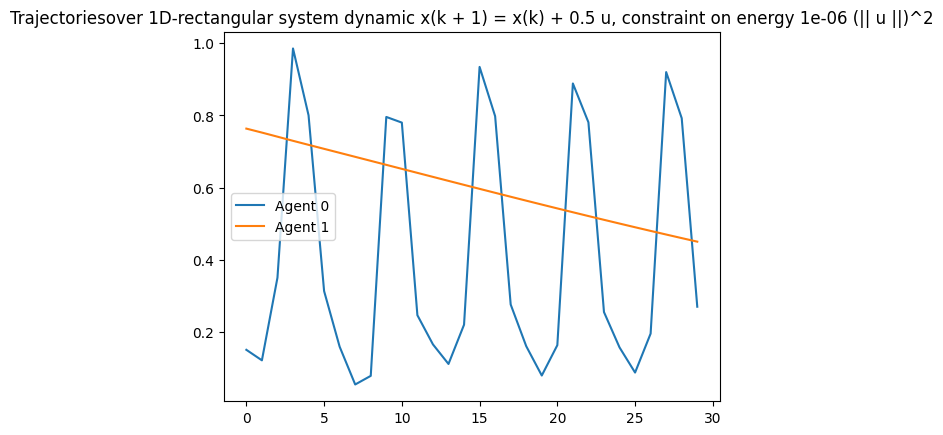

In [ ]:
#plot trajectory
model.eval()
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()



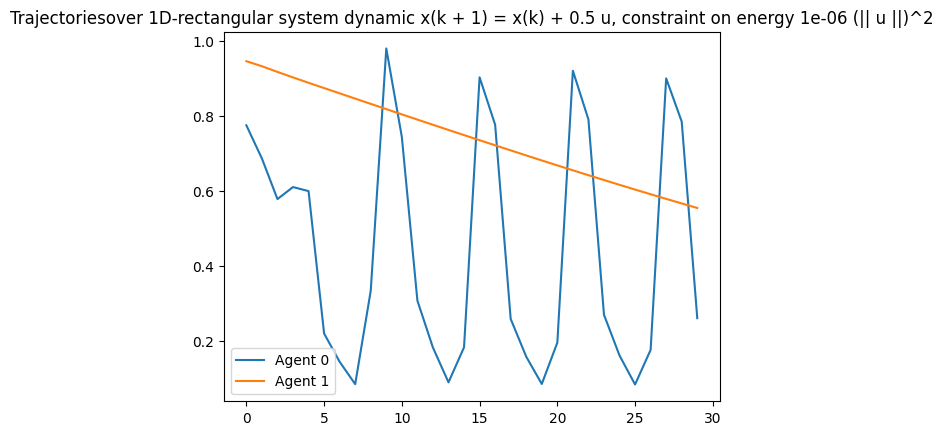

model tensor([3.8804e-08, 5.4326e-08, 5.4326e-08, 6.2086e-08, 8.5369e-08, 9.3130e-08,
        1.2417e-07, 1.4746e-07, 1.8626e-07, 2.1730e-07, 2.7163e-07, 3.2595e-07,
        4.1132e-07, 4.9669e-07, 5.8982e-07, 7.2951e-07, 8.9249e-07, 1.0943e-06,
        1.3426e-06, 1.6375e-06, 1.9945e-06, 2.4369e-06, 2.9879e-06, 3.6476e-06,
        4.4547e-06, 5.4403e-06, 6.6432e-06, 8.1178e-06, 9.9183e-06, 1.2122e-05,
        1.4800e-05, 1.8083e-05, 2.2087e-05, 2.6992e-05, 3.2968e-05, 4.0279e-05,
        4.9219e-05, 6.0115e-05, 7.3433e-05, 8.9715e-05, 1.0960e-04, 1.3388e-04,
        1.6356e-04, 1.9980e-04, 2.4407e-04, 2.9815e-04, 3.6421e-04, 4.4490e-04,
        5.4346e-04, 6.6381e-04, 8.1082e-04, 9.9034e-04, 1.2096e-03, 1.4772e-03,
        1.8040e-03, 2.2029e-03, 2.6898e-03, 3.2838e-03, 4.0085e-03, 4.8923e-03,
        5.9697e-03, 7.2825e-03, 8.8812e-03, 1.0827e-02, 1.3193e-02, 1.6066e-02,
        1.9553e-02, 2.3776e-02, 2.8883e-02, 3.5044e-02, 4.2459e-02, 5.1354e-02,
        6.1983e-02, 7.4630e-02, 8.

tensor(0.8034, grad_fn=<AddBackward0>)

In [ ]:
import Ergodic_Loss_timedomain
import sys
sys.path.append(r'\\hhi.de\benutzer\home\prass\Master\Code_RNN_KAN\Recursive_kan\Ergodic_Loss_timedomain.py') 
import importlib
importlib.reload(Ergodic_Loss_timedomain)
criterion = Ergodic_Loss_timedomain.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim,control_energy_reg = control_energy_reg, density = 'custom', pdf = custom_pdf, max_pdf = 1, num_samples = 1000)
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()
criterion.verbose = True
criterion(x = outs, u = control)

In [ ]:
indices = torch.nonzero(criterion.function_values[0] > 0)
print(indices)
criterion.samples[indices]

tensor([[  0],
        [  1],
        [  2],
        [  3],
        [  4],
        [  5],
        [  6],
        [  7],
        [  8],
        [  9],
        [ 10],
        [ 11],
        [ 12],
        [ 13],
        [ 14],
        [ 15],
        [ 16],
        [ 17],
        [ 18],
        [ 19],
        [ 20],
        [ 21],
        [ 22],
        [ 23],
        [ 24],
        [ 25],
        [ 26],
        [ 27],
        [ 28],
        [ 29],
        [ 30],
        [ 31],
        [ 32],
        [ 33],
        [ 34],
        [ 35],
        [ 36],
        [ 37],
        [ 38],
        [ 39],
        [ 40],
        [ 41],
        [ 42],
        [ 43],
        [ 44],
        [ 45],
        [ 46],
        [ 47],
        [ 48],
        [ 49],
        [ 50],
        [ 51],
        [ 52],
        [ 53],
        [ 54],
        [ 55],
        [ 56],
        [ 57],
        [ 58],
        [ 59],
        [ 60],
        [ 61],
        [ 62],
        [ 63],
        [ 64],
        [ 65],
        [ 

tensor([[1.0000e-05],
        [1.0110e-03],
        [2.0120e-03],
        [3.0129e-03],
        [4.0139e-03],
        [5.0149e-03],
        [6.0159e-03],
        [7.0169e-03],
        [8.0178e-03],
        [9.0188e-03],
        [1.0020e-02],
        [1.1021e-02],
        [1.2022e-02],
        [1.3023e-02],
        [1.4024e-02],
        [1.5025e-02],
        [1.6026e-02],
        [1.7027e-02],
        [1.8028e-02],
        [1.9029e-02],
        [2.0030e-02],
        [2.1031e-02],
        [2.2032e-02],
        [2.3033e-02],
        [2.4034e-02],
        [2.5035e-02],
        [2.6036e-02],
        [2.7036e-02],
        [2.8037e-02],
        [2.9038e-02],
        [3.0039e-02],
        [3.1040e-02],
        [3.2041e-02],
        [3.3042e-02],
        [3.4043e-02],
        [3.5044e-02],
        [3.6045e-02],
        [3.7046e-02],
        [3.8047e-02],
        [3.9048e-02],
        [4.0049e-02],
        [4.1050e-02],
        [4.2051e-02],
        [4.3052e-02],
        [4.4053e-02],
        [4

In [ ]:
criterion(x = outs, u = control)

model tensor([9.8122e-03, 1.1882e-02, 1.4362e-02, 1.7321e-02, 2.0834e-02, 2.4983e-02,
        2.9848e-02, 3.5508e-02, 4.2033e-02, 4.9475e-02, 5.7861e-02, 6.7182e-02,
        7.7386e-02, 8.8375e-02, 9.9997e-02, 1.1206e-01, 1.2434e-01, 1.3659e-01,
        1.4857e-01, 1.6007e-01, 1.7089e-01, 1.8091e-01, 1.9002e-01, 1.9819e-01,
        2.0543e-01, 2.1175e-01, 2.1723e-01, 2.2193e-01, 2.2593e-01, 2.2931e-01,
        2.3216e-01, 2.3454e-01, 2.3653e-01, 2.3818e-01, 2.3956e-01, 2.4069e-01,
        2.4164e-01, 2.4241e-01, 2.4306e-01, 2.4359e-01, 2.4403e-01, 2.4440e-01,
        2.4471e-01, 2.4497e-01, 2.4520e-01, 2.4539e-01, 2.4557e-01, 2.4573e-01,
        2.4589e-01, 2.4604e-01, 2.4620e-01, 2.4637e-01, 2.4656e-01, 2.4677e-01,
        2.4702e-01, 2.4731e-01, 2.4766e-01, 2.4808e-01, 2.4858e-01, 2.4919e-01,
        2.4992e-01, 2.5081e-01, 2.5189e-01, 2.5320e-01, 2.5479e-01, 2.5671e-01,
        2.5902e-01, 2.6181e-01, 2.6516e-01, 2.6918e-01, 2.7396e-01, 2.7964e-01,
        2.8633e-01, 2.9419e-01, 3.

tensor(0.8230, grad_fn=<AddBackward0>)